In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import pickle

In [3]:
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
sns.set()
%matplotlib inline

In [4]:
# Sklearn-preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import class_weight
from category_encoders import TargetEncoder

In [5]:
# Machine Learning Algorithms
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, IsolationForest,
                              RandomForestRegressor, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier)
from lightgbm import LGBMClassifier
from sklearn.linear_model import Perceptron

In [6]:
# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
planets = pd.read_csv('/content/sample_data/hwc.csv')
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


In [10]:
planets.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


Handling Missing Data

In [11]:
#Handle missing data
# Calculate percentage of missing values for each column
missing_percentages = planets.isnull().mean() * 100

# Identify columns with more than 40% missing values
columns_to_drop = missing_percentages[missing_percentages > 40].index.tolist()

In [12]:
columns_to_drop

['P_MASS_ERROR_MIN',
 'P_MASS_ERROR_MAX',
 'P_SEMI_MAJOR_AXIS_ERROR_MIN',
 'P_SEMI_MAJOR_AXIS_ERROR_MAX',
 'P_ECCENTRICITY_ERROR_MIN',
 'P_ECCENTRICITY_ERROR_MAX',
 'P_INCLINATION_ERROR_MIN',
 'P_INCLINATION_ERROR_MAX',
 'P_OMEGA',
 'P_OMEGA_ERROR_MIN',
 'P_OMEGA_ERROR_MAX',
 'S_NAME_HD',
 'S_NAME_HIP',
 'S_TYPE',
 'S_LOG_LUM_ERROR_MIN',
 'S_LOG_LUM_ERROR_MAX',
 'P_TEMP_SURF']

In [13]:
# Drop the identified columns from the DataFrame
planets = planets.drop(columns=columns_to_drop)

In [14]:
#delete some unnecessary columns
unnecessary_columns=["P_NAME", "P_DETECTION", "P_DISCOVERY_FACILITY", "P_UPDATE", "P_YEAR"]
planets = planets.drop(columns=unnecessary_columns)

In [15]:
#drop P_ESI as it leaks information about habitibility
planets = planets.drop(columns="P_ESI")

In [16]:
missing_values = planets.isnull().sum()
missing_values = missing_values[missing_values > 0]

In [17]:
print(missing_values)

P_MASS                   7
P_RADIUS                 7
P_RADIUS_ERROR_MIN    1739
P_RADIUS_ERROR_MAX    1739
P_PERIOD               246
                      ... 
S_HZ_CON1_MAX          230
S_SNOW_LINE            230
S_ABIO_ZONE            220
S_TIDAL_LOCK             4
P_TYPE_TEMP            231
Length: 67, dtype: int64


In [18]:
# Count missing values as a percentage of total values
missing_percentage = (planets.isnull().sum() / len(planets)) * 100
missing_percentage = missing_percentage[missing_percentage > 30]

# Display the result
print(missing_percentage)

P_RADIUS_ERROR_MIN    31.226432
P_RADIUS_ERROR_MAX    31.226432
dtype: float64


In [19]:
planets = planets.drop(columns=["P_RADIUS_ERROR_MIN","P_RADIUS_ERROR_MAX"])

In [20]:
# Separate numerical and categorical columns
numerical_columns = planets.select_dtypes(include=['int', 'float']).columns
categorical_columns = planets.select_dtypes(include=['object']).columns

# Impute missing values for numerical columns using mean strategy
numerical_imputer = SimpleImputer(strategy='mean')
planets[numerical_columns] = numerical_imputer.fit_transform(planets[numerical_columns])

# Impute missing values for categorical columns using most frequent strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
planets[categorical_columns] = categorical_imputer.fit_transform(planets[categorical_columns])

In [21]:
# Any missing values?
print(planets.isnull().values.any())

False


Data Scaling/Normalization

In [22]:
# Separate features (X) and target variable (y), if applicable
X = planets.drop(columns=['P_HABITABLE'])  # Exclude the target column, if present
y = planets['P_HABITABLE']  # Include the target column, if present

# Select only the numerical columns in the feature matrix
numerical_columns = X.select_dtypes(include=['int', 'float']).columns

# Exclude the target variable from the numerical columns
if 'P_HABITABLE' in numerical_columns:
    numerical_columns = numerical_columns.drop('target_column')

# Extract the numerical features
X_numerical = X[numerical_columns]

# Standardization
standard_scaler = StandardScaler()
X_scaled_numerical = standard_scaler.fit_transform(X_numerical)

# Create a DataFrame for the scaled numerical features
X_scaled_numerical_df = pd.DataFrame(X_scaled_numerical, columns=numerical_columns)

# Concatenate the scaled numerical features with the original categorical features
planets_scaled = pd.concat([X_scaled_numerical_df, X.select_dtypes(exclude=['int', 'float'])], axis=1)

# Concatenate the scaled numerical features with the target variable, if applicable
if 'P_HABITABLE' in planets.columns:
    planets_scaled = pd.concat([planets_scaled, y.reset_index(drop=True)], axis=1)

In [23]:
planets_scaled.head()

,P_MASS,P_MASS_LIMIT,P_RADIUS,P_RADIUS_LIMIT,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_PERIOD_LIMIT,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_LIMIT,...,S_DEC_STR,P_TYPE,S_TYPE_TEMP,S_RA_TXT,S_DEC_TXT,P_TYPE_TEMP,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_HABITABLE
0,-0.080523,-0.141768,1.533424,0.02681,-2.700355e-18,2.711107e-18,-4.621304e-18,0.018954,-0.022475,0.023216,...,-33d45m35.2s,Jovian,G,17 42 23.31,-33 45 35.20,Hot,Scorpius,Sco,Scorpion,0.0
1,-0.179047,-0.141768,-0.527842,0.02681,-1.490503e-02,2.711107e-18,-4.621304e-18,0.018954,-0.046912,0.023216,...,+39d02m10.72s,Neptunian,G,19 34 16.37,+39 02 10.72,Hot,Cygnus,Cyg,Swan,0.0
2,-0.183902,-0.141768,-0.675878,0.02681,-1.490967e-02,1.681481e-02,-1.568550e-02,0.018954,-0.047917,0.023216,...,+42d27m49.73s,Superterran,G,18 49 19.88,+42 27 49.73,Hot,Lyra,Lyr,Lyre,0.0
3,-0.180905,-0.141768,-0.411662,0.02681,-1.491059e-02,1.681481e-02,-1.568550e-02,0.018954,-0.048213,0.023216,...,+09d41m34.51s,Neptunian,K,00 52 46.65,+09 41 34.51,Hot,Pisces,Psc,Fishes,0.0
4,-0.183969,-0.141768,-0.683374,0.02681,-1.490889e-02,1.681481e-02,-1.568550e-02,0.018954,-0.047739,0.023216,...,+42d21m19.10s,Superterran,K,19 12 16.19,+42 21 19.10,Hot,Lyra,Lyr,Lyre,0.0


Encoding Catergorical values

In [24]:
categorical_columns = planets_scaled.select_dtypes(include=['object']).columns
categorical_columns

Index(['P_MASS_ORIGIN', 'S_NAME', 'S_RA_STR', 'S_DEC_STR', 'P_TYPE',
       'S_TYPE_TEMP', 'S_RA_TXT', 'S_DEC_TXT', 'P_TYPE_TEMP',
       'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG'],
      dtype='object')

In [25]:
categorical_columns_selected = [
    'P_MASS_ORIGIN',
    'S_NAME',
    'P_TYPE',
    'P_TYPE_TEMP',
    'S_TYPE_TEMP',
    'S_CONSTELLATION',
    'S_CONSTELLATION_ABR',
    'S_CONSTELLATION_ENG'
]
#For features like 'S_RA_STR', 'S_DEC_STR', 'S_RA_TXT', and 'S_DEC_TXT', encoding may not be necessary as we plan to use their numerical values directly.
# Apply one-hot encoding to selected categorical columns
encoded_planets = pd.get_dummies(planets_scaled, columns=categorical_columns_selected, drop_first=True)

In [26]:
encoded_planets.columns

Index(['P_MASS', 'P_MASS_LIMIT', 'P_RADIUS', 'P_RADIUS_LIMIT', 'P_PERIOD',
       'P_PERIOD_ERROR_MIN', 'P_PERIOD_ERROR_MAX', 'P_PERIOD_LIMIT',
       'P_SEMI_MAJOR_AXIS', 'P_SEMI_MAJOR_AXIS_LIMIT',
       ...
       'S_CONSTELLATION_ENG_Toucan', 'S_CONSTELLATION_ENG_Triangle',
       'S_CONSTELLATION_ENG_Twins', 'S_CONSTELLATION_ENG_Unicorn',
       'S_CONSTELLATION_ENG_Virgin', 'S_CONSTELLATION_ENG_Water Carrier',
       'S_CONSTELLATION_ENG_Water Snake', 'S_CONSTELLATION_ENG_Whale',
       'S_CONSTELLATION_ENG_Winged Horse', 'S_CONSTELLATION_ENG_Wolf'],
      dtype='object', length=4511)

In [27]:
categorical_columns = encoded_planets.select_dtypes(include=['object']).columns
encoded_planets = encoded_planets.drop(columns=categorical_columns)

Feature Selection/Dimensionality Reduction

In [28]:
# Checking correlation of different features to the target column
corr_mtrx = encoded_planets.corr()
corr_df = pd.DataFrame(corr_mtrx['P_HABITABLE'].sort_values(ascending=False))
corr_df.head(10)

,P_HABITABLE
P_HABITABLE,1.000000
P_HABZONE_OPT,0.479930
P_TYPE_TEMP_Warm,0.479930
P_HABZONE_CON,0.317465
S_TYPE_TEMP_M,0.212243
S_NAME_GJ 180,0.166505
S_NAME_TOI-2257,0.144888
S_NAME_HN Lib,0.144888
S_NAME_Kepler-1638,0.144888
S_NAME_Ross 508,0.144888


In [29]:
corr_df.tail(18)

,P_HABITABLE
P_RADIUS,-0.076241
S_TYPE_TEMP_G,-0.082136
S_TEMPERATURE,-0.095650
S_MASS,-0.121056
P_TEMP_SURF_MIN,-0.123931
P_TEMP_EQUIL_MIN,-0.123931
P_TEMP_SURF_MAX,-0.124081
P_TEMP_EQUIL_MAX,-0.124081
P_TEMP_EQUIL,-0.124494
S_TIDAL_LOCK,-0.128172


In [30]:
#Removing the non correlated features
encoded_planets = encoded_planets.drop(columns=["P_OMEGA_LIMIT", "S_MASS_LIMIT", "S_RADIUS_LIMIT", "S_LOG_LUM_LIMIT"])

In [31]:
from sklearn.decomposition import PCA

# Assuming your dataset is loaded into a pandas DataFrame named 'planets_encoded'

# Define the number of components (desired dimensions after reduction)
n_components = 500  # You can adjust this number based on your requirements

# Separate features (X) and target variable (y), if applicable
X = encoded_planets.drop(columns=['P_HABITABLE'])  # Exclude the target column, if present
y = encoded_planets['P_HABITABLE']  # Include the target column, if present

# Initialize PCA with the desired number of components
pca = PCA(n_components=n_components)

# Fit PCA to the features
pca.fit(X)

# Transform the features to the reduced-dimensional space
X_pca = pca.transform(X)

# Create a DataFrame for the transformed features
pca_planets = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the transformed features with the target variable, if applicable
if 'P_HABITABLE' in encoded_planets.columns:
    pca_planets = pd.concat([pca_planets, y.reset_index(drop=True)], axis=1)

# Now X_pca_df contains the dataset with reduced dimensions using PCA


In [32]:
pca_planets.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500,P_HABITABLE
0,-0.418773,0.286873,-0.315869,0.436423,1.019790,-1.348815,0.422686,-0.284318,0.023688,0.599125,...,-0.000491,0.002042,-0.000984,-0.002720,-0.001314,-0.000174,0.000162,0.003265,0.001908,0.0
1,-0.922706,-0.043153,-0.023887,-1.957045,0.704049,0.284550,-0.215824,-0.140078,0.729727,0.918585,...,0.000141,0.000124,-0.001284,-0.000088,-0.001890,0.001994,0.001959,-0.000950,-0.002755,0.0
2,-0.713606,-0.680805,1.444952,-1.247353,-0.490670,0.231620,-0.128264,-0.067919,-0.408619,-0.787942,...,-0.004114,0.001834,0.001523,-0.001310,-0.000005,-0.001626,0.000217,0.001216,-0.002026,0.0
3,-0.993883,-0.287420,0.516383,1.858364,-1.189548,-0.519184,-0.220392,-0.008394,-1.080541,-0.064043,...,0.006625,0.000255,-0.004592,-0.003987,-0.001994,-0.004844,-0.002621,-0.000947,0.005440,0.0
4,-1.239529,-0.011912,-0.361366,0.017714,-0.842437,-0.300539,0.324093,-0.415065,-0.518150,0.672395,...,-0.000273,-0.001282,-0.001448,0.000315,-0.001483,-0.000851,0.000674,0.003091,0.000993,0.0


Train-test split

In [33]:
X_plan = pca_planets.drop(columns=['P_HABITABLE'])  # Exclude the target column, if present
y_plan = pca_planets['P_HABITABLE']  # Include the target column, if present

# Perform the test-train split
X_train, X_test, y_train, y_test = train_test_split(X_plan, y_plan, test_size=0.2, random_state=42)

In [34]:
X_train.shape

(4455, 500)

Checking skewness

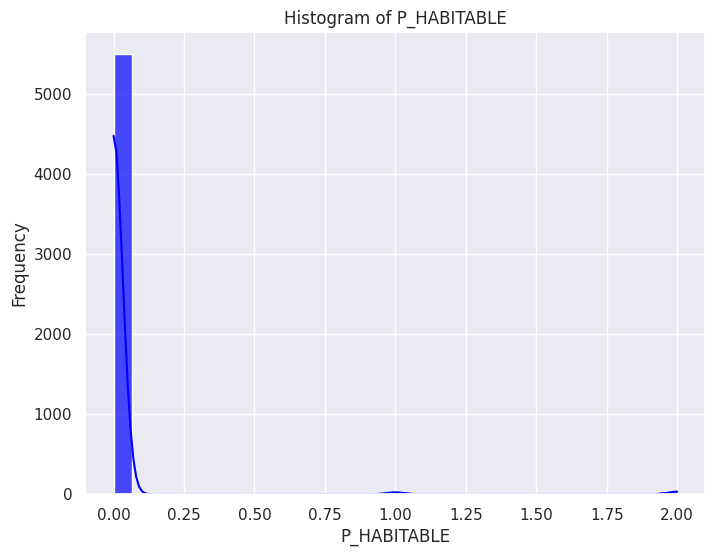

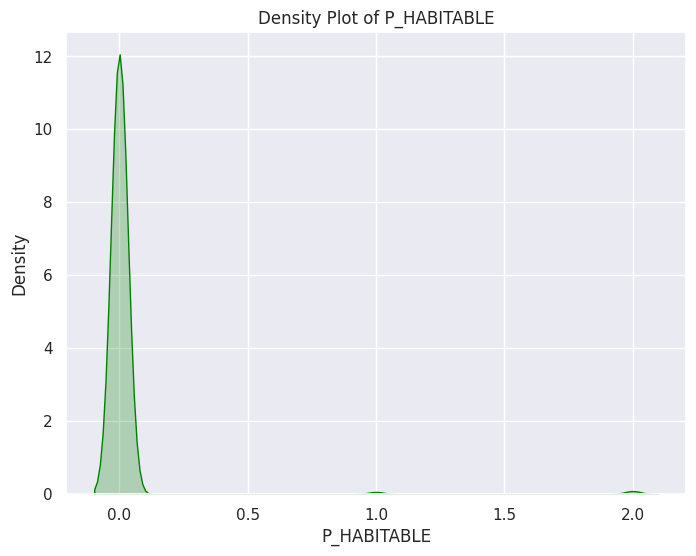

In [35]:
plt.figure(figsize=(8, 6))
sns.histplot(pca_planets['P_HABITABLE'], bins=30, kde=True, color='blue', alpha=0.7)
plt.title('Histogram of P_HABITABLE')
plt.xlabel('P_HABITABLE')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot density plot of the target variable
plt.figure(figsize=(8, 6))
sns.kdeplot(pca_planets['P_HABITABLE'], color='green', shade=True)
plt.title('Density Plot of P_HABITABLE')
plt.xlabel('P_HABITABLE')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [36]:
# Calculate the skewness of the target variable
skewness = pca_planets['P_HABITABLE'].skew()

# Print the skewness
print("Skewness of the P_HABITABLE", skewness)

Skewness of the P_HABITABLE 9.876581148322755


<Axes: title={'center': 'Class Count'}>

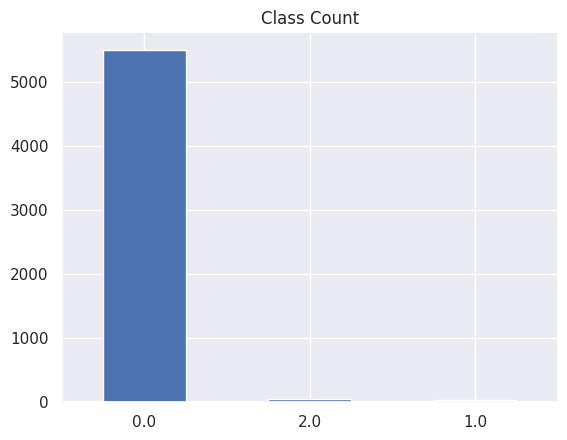

In [37]:
target_count = pca_planets['P_HABITABLE'].value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0)

In [38]:
print("Class Counts:")
print(target_count)

Class Counts:
0.0    5500
2.0      40
1.0      29
Name: P_HABITABLE, dtype: int64


In [39]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [40]:
X_train_resampled.shape

(13197, 500)

<Axes: >

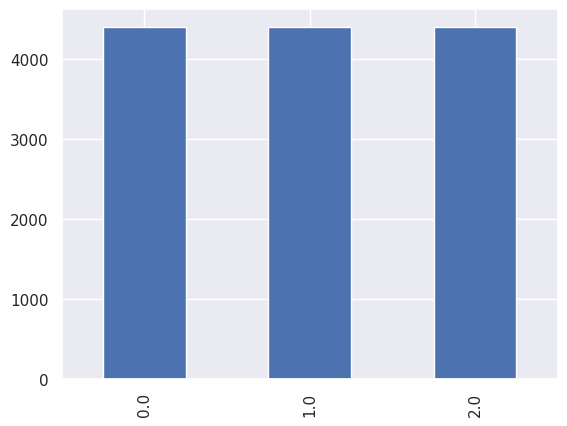

In [41]:
pd.Series(y_train_resampled).value_counts().plot.bar()

Machine Learning Models

In [42]:
# Define models
from xgboost import XGBClassifier
from tqdm import tqdm
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# Create a DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

# Train and evaluate models
for name, model in tqdm(models.items(), desc="Training Models", total=len(models)):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results = results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}, ignore_index=True)

# Print results
print(results)

# Save results to a CSV file
results.to_csv('model_results.csv', index=False)


GPU available: []


Training Models:  89%|████████▉ | 8/9 [15:02<01:11, 71.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 13197, number of used features: 500
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Training Models: 100%|██████████| 9/9 [15:31<00:00, 103.45s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.999102   0.999184  0.999102  0.999124
1        Decision Tree  0.989228   0.992168  0.989228  0.990342
2        Random Forest  0.991023   0.991089  0.991023  0.987735
3    Gradient Boosting  0.999102   0.999327  0.999102  0.999143
4                  SVM  0.997307   0.997695  0.997307  0.997434
5  K-Nearest Neighbors  0.985637   0.990672  0.985637  0.987719
6          Naive Bayes  0.429084   0.980126  0.429084  0.592659
7              XGBoost  0.998205   0.998205  0.998205  0.998181
8             LightGBM  0.996409   0.996414  0.996409  0.996311


Logistic Regression, Gradient Boosting, XGBoost, performed the best. We will proceed will save the models.

In [43]:
# Sort the results DataFrame based on F1-score in descending order
sorted_results = results.sort_values(by='F1-score', ascending=False)

# Get the top 3 best performing models
top_models = sorted_results.head(3)

# Save each top model along with its name using pickle dump
for idx, row in top_models.iterrows():
    model_name = row['Model']
    model = models[model_name]
    filename = f"{model_name}_model.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


In [44]:
import pickle

# Find the model with the highest F1-score
best_model_row = results.loc[results['F1-score'].idxmax()]

# Extract model name and initialize the corresponding model
best_model_name = best_model_row['Model']
best_model = models[best_model_name]

# Train the identified model again on the full dataset
best_model.fit(X_train_resampled, y_train_resampled)

# Save the trained model using pickle.dump()
with open(f'best_model_{best_model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"The best performing model '{best_model_name}' has been saved.")


The best performing model 'Gradient Boosting' has been saved.


Model optimization If required

In [ ]:
# # Define parameter grids for each model
# param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Hyperparameter grid for Logistic Regression
# param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}  # Hyperparameter grid for Gradient Boosting
# param_grid_xgb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}  # Hyperparameter grid for XGBoost

# # Initialize GridSearchCV for each model
# grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1_weighted')
# grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, scoring='f1_weighted')
# grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, scoring='f1_weighted')

# # Fit GridSearchCV on the training data
# grid_search_lr.fit(X_train_resampled, y_train_resampled)
# grid_search_gb.fit(X_train_resampled, y_train_resampled)
# grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# # Get best hyperparameters and best score for each model
# best_params_lr = grid_search_lr.best_params_
# best_score_lr = grid_search_lr.best_score_

# best_params_gb = grid_search_gb.best_params_
# best_score_gb = grid_search_gb.best_score_

# best_params_xgb = grid_search_xgb.best_params_
# best_score_xgb = grid_search_xgb.best_score_

# # Print best hyperparameters and best score for each model
# print("Logistic Regression:")
# print("Best Hyperparameters:", best_params_lr)
# print("Best Score:", best_score_lr)
# print()

# print("Gradient Boosting:")
# print("Best Hyperparameters:", best_params_gb)
# print("Best Score:", best_score_gb)
# print()

# print("XGBoost:")
# print("Best Hyperparameters:", best_params_xgb)
# print("Best Score:", best_score_xgb)